In [6]:
"""
Traditional Weather Analogue Metrics Searching
=============================================

This notebook implements traditional metrics for finding weather analogues:
- Cosine similarity
- Euclidean similarity
- Structural Similarity Index (SSIM)

The notebook searches for analogues to historical weather events and 
saves the results for further analysis.
"""

# Standard library imports
import copy
import datetime
import json
import math
import os
import random
import sys
from pathlib import Path

# Data handling and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial.distance import euclidean, cosine
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from skimage.metrics import structural_similarity as ssim

# Unused imports have been removed

In [7]:
def setup_environment():
    """
    Set up the project environment by configuring paths and importing project modules.
    
    Returns:
        str: Current working directory
    """
    try:
        # Navigate to project root directory
        os.chdir("../")
    except Exception as e:
        print(f"Error changing directory: {e}")
    
    # Get and print current working directory
    current_directory = os.getcwd()
    print(f"Current Directory: {current_directory}")
    
    # Add project paths to sys.path
    sys.path.append(os.path.abspath(os.path.join(current_directory, "notebooks")))
    
    return current_directory

# Set up environment
current_directory = setup_environment()

# Import project utilities
from utils.utils import set_working_directory, load_json_config
from utils.utils_data import read_netcdf
from utils.utils_parsers import batch_data_parser, model_parser, feature_map_parser
from utils.utils_analog import (
    generate_time_weights, cosine_similarity, euclidean_similarity, 
    ssim_similarity, search_analogs, revise_analogs, 
    attach_data_to_analogs, plot_analogs, plot_analogs_with_band
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (10, 6),
})

Current Directory: /home/yuhan/Desktop/Master


## Data Loading and Preprocessing

In this section, we load the ERA5 reanalysis data, spatial and variable weights, and historical event data.

### Load ERA5 Reanalysis Data

In [8]:
def load_era5_data(variable_group, freq, time_unit, method, preprocessing, years):
    """
    Load ERA5 reanalysis data based on specified parameters.
    
    Args:
        variable_group (str): Combined variable names (e.g., 'd2muvmslr')
        freq (int): Temporal frequency
        time_unit (str): Time unit ('h' for hours, 'd' for days)
        method (str): Resampling method
        preprocessing (str): Preprocessing method ('raw', 'standardized', 'normalized')
        years (tuple): Start and end years (inclusive)
        
    Returns:
        list: List of (timestamp, data_array) tuples
    """
    # Construct file path
    file_path = f"data/processed/{variable_group}_{freq}{time_unit}_{method}_{preprocessing}_{years[0]}{years[1]}.h5"
    print(f"Loading data from: {file_path}")
    
    try:
        data = read_netcdf(file_path)
        print(f"Data loaded successfully with {len(data)} time points")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Data parameters
VARIABLE_GROUP = "d2muvmslr"  # Combined variable names
VARIABLE_LIST = ["d2m", "u", "v", "msl", "r"]  # Individual variables
FREQUENCY = 1  # Hourly data
TIME_UNIT = "h"  # Hours
RESAMPLE_METHOD = "none"  # No resampling
YEAR_RANGE = (2004, 2020)  # Study period

# Define data paths for different preprocessing methods
data_paths = {
    "raw": f"data/processed/{VARIABLE_GROUP}_{FREQUENCY}{TIME_UNIT}_{RESAMPLE_METHOD}_raw_{YEAR_RANGE[0]}{YEAR_RANGE[1]}.h5",
    "standardized": f"data/processed/{VARIABLE_GROUP}_{FREQUENCY}{TIME_UNIT}_{RESAMPLE_METHOD}_standardized_{YEAR_RANGE[0]}{YEAR_RANGE[1]}.h5",
    "normalized": f"data/processed/{VARIABLE_GROUP}_{FREQUENCY}{TIME_UNIT}_{RESAMPLE_METHOD}_normalized_{YEAR_RANGE[0]}{YEAR_RANGE[1]}.h5",
    "precipitation": f"data/processed/tp_{FREQUENCY}{TIME_UNIT}_{RESAMPLE_METHOD}_raw_{YEAR_RANGE[0]}{YEAR_RANGE[1]}.h5"
}

# Load raw data (we'll use this for the analysis)
era5_data = load_era5_data(
    VARIABLE_GROUP, FREQUENCY, TIME_UNIT, 
    RESAMPLE_METHOD, "raw", YEAR_RANGE
)

# Print data sample information
print(f"Data time range: {era5_data[0][0]} to {era5_data[-1][0]}")
print(f"Data shape: {era5_data[0][1].shape}")
print(f"Variables: {VARIABLE_LIST}")

Loading data from: data/processed/d2muvmslr_1h_none_raw_20042020.h5
Data loaded successfully with 146736 time points
Data time range: 2004-04-06T00:00:00.000000000 to 2020-12-31T23:00:00.000000000
Data shape: (5, 32, 32)
Variables: ['d2m', 'u', 'v', 'msl', 'r']
Data loaded successfully with 146736 time points
Data time range: 2004-04-06T00:00:00.000000000 to 2020-12-31T23:00:00.000000000
Data shape: (5, 32, 32)
Variables: ['d2m', 'u', 'v', 'msl', 'r']


### Load Spatial and Variable Weights

Weights are used to emphasize important regions and variables in the analogue search process.

In [12]:
def load_weights(file_path):
    """
    Load spatial and variable weights from a JSON file.
    
    Args:
        file_path (str): Path to the weights JSON file
        
    Returns:
        tuple: (grid_weights, variable_weights, time_weights)
    """
    try:
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            
        grid_weights = np.array(loaded_data.get('grid_weights', []))
        variable_weights = loaded_data.get("variable_weights", [])
        time_weights = loaded_data.get("time_weights", [])
        
        return grid_weights, variable_weights, time_weights
    except Exception as e:
        print(f"Error loading weights: {e}")
        return None, None, None

# Load weights from file
weights_path = 'yu-ml-weather-analogue/data/raw/weights.json'
grid_weights, variable_weights, time_weights = load_weights(weights_path)

# Print weights information
print("Grid weights shape:", grid_weights.shape)
print("Variable weights:", {var: weight for var, weight in zip(VARIABLE_LIST, variable_weights)})
print("Time weights:", time_weights)

Grid weights shape: (32, 32)
Variable weights: {'d2m': 0.06815204455345274, 'u': 0.2618559078734947, 'v': 0.032406131564035955, 'msl': 0.15535458631344512, 'r': 0.4822313296955715}
Time weights: [0.21428571428571427, 0.19047619047619047, 0.16666666666666666, 0.14285714285714285, 0.11904761904761904, 0.09523809523809523, 0.07142857142857142]


In [13]:
def load_events(file_path):
    """
    Load historical events from a CSV file.
    
    Args:
        file_path (str): Path to the events CSV file
        
    Returns:
        pandas.DataFrame: DataFrame containing event information
    """
    try:
        # Read events CSV file
        events_df = pd.read_csv(file_path)
        
        # Sort events by rank
        events_df = events_df.sort_values(by="Rank")
        
        # Convert date strings to datetime objects
        events_df["start datetime"] = pd.to_datetime(events_df["start datetime"])
        events_df["end datetime"] = pd.to_datetime(events_df["end datetime"])
        
        # Calculate event duration
        events_df["duration_hours"] = (events_df["end datetime"] - 
                                      events_df["start datetime"]).dt.total_seconds() / 3600
        
        return events_df
    except Exception as e:
        print(f"Error loading events: {e}")
        return None

# Load historical flood events
events_path = "yu-ml-weather-analogue/data/raw/events_flood.csv"
events_df = load_events(events_path)

# Display event information
print(f"Loaded {len(events_df)} historical events")
print(f"Event time range: {events_df['start datetime'].min()} to {events_df['end datetime'].max()}")
print(f"Average event duration: {events_df['duration_hours'].mean():.1f} hours")

# Display the first few events
events_df.head()

Loaded 157 historical events
Event time range: 2005-07-04 03:00:00 to 2017-07-12 00:00:00
Average event duration: 21.1 hours


,Rank,ID,start datetime,end datetime,duration,duration_hours
0,1,2464,2014-07-08 10:00:00,2014-07-08 20:00:00,10.0,10.0
1,2,632,2006-08-29 11:00:00,2006-08-29 14:00:00,3.0,3.0
2,3,1998,2012-07-18 05:00:00,2012-07-19 04:00:00,23.0,23.0
3,4,481,2005-12-31 20:00:00,2006-01-01 04:00:00,8.0,8.0
4,5,2879,2016-04-04 06:00:00,2016-04-04 16:00:00,10.0,10.0


## Analogue Search Configuration

This section defines the configuration parameters for the analogue search process.

### Parameter Settings

Define the parameters for the analogue search, including event selection, time windows, and similarity metrics.

In [14]:
class AnalogueSearchConfig:
    """Configuration class for analogue search parameters"""
    
    def __init__(self):
        # Event selection
        self.event_index = 24  # Index of the target event in events_df
        
        # Time windows
        self.time_window = 6  # Hours to consider before event
        self.lead_time = 3  # Lead time for prediction
        
        # Project identifier and similarity method
        self.project = "second_phase"  # Project name for file organization
        self.similarity_method = euclidean_similarity  # Similarity function
        
        # Search parameters
        self.event_number = 157  # Number of events to process
        self.analogue_number = 120  # Number of analogues to find initially
        self.result_number = 120  # Number of analogues to keep after filtering
        
        # Filtering options
        self.remove_predicting_event = True  # Remove the event itself
        self.remove_overlapping_events = False  # Remove events that overlap in time
        self.remove_extra_events = True  # Limit to result_number
        
        # Output directory and file
        self.directory = f'data/analogs/{self.project}'
        os.makedirs(self.directory, exist_ok=True)
        self.file_path = f'{self.directory}/{self.similarity_method.__name__}.json'
    
    def get_event_info(self, events_df):
        """Get information about the selected event"""
        event = events_df.iloc[self.event_index]
        return {
            'id': event.get('ID', self.event_index),
            'start_time': event['start datetime'],
            'end_time': event['end datetime'],
            'duration_hours': (event['end datetime'] - event['start datetime']).total_seconds() / 3600,
            'rank': event.get('Rank', 'N/A')
        }
    
    def print_summary(self, events_df):
        """Print a summary of the search configuration"""
        event_info = self.get_event_info(events_df)
        
        print("=== Analogue Search Configuration ===")
        print(f"Project: {self.project}")
        print(f"Similarity method: {self.similarity_method.__name__}")
        print(f"\nTarget event (index {self.event_index}):")
        print(f"  - Start time: {event_info['start_time']}")
        print(f"  - End time: {event_info['end_time']}")
        print(f"  - Duration: {event_info['duration_hours']:.1f} hours")
        print(f"  - Rank: {event_info['rank']}")
        
        print(f"\nSearch parameters:")
        print(f"  - Time window: {self.time_window} hours")
        print(f"  - Lead time: {self.lead_time} hours")
        print(f"  - Initial analogues: {self.analogue_number}")
        print(f"  - Final analogues: {self.result_number}")
        
        print(f"\nFiltering options:")
        print(f"  - Remove predicting event: {self.remove_predicting_event}")
        print(f"  - Remove overlapping events: {self.remove_overlapping_events}")
        print(f"  - Remove extra events: {self.remove_extra_events}")
        
        print(f"\nOutput file: {self.file_path}")

# Create and initialize configuration
config = AnalogueSearchConfig()

# Print configuration summary
config.print_summary(events_df)

# Extract target event information for convenience
target_event_info = config.get_event_info(events_df)
target_start_time = target_event_info['start_time']
target_end_time = target_event_info['end_time']

=== Analogue Search Configuration ===
Project: second_phase
Similarity method: euclidean_similarity

Target event (index 24):
  - Start time: 2011-08-07 13:00:00
  - End time: 2011-08-07 23:00:00
  - Duration: 10.0 hours
  - Rank: 25

Search parameters:
  - Time window: 6 hours
  - Lead time: 3 hours
  - Initial analogues: 120
  - Final analogues: 120

Filtering options:
  - Remove predicting event: True
  - Remove overlapping events: False
  - Remove extra events: True

Output file: data/analogs/second_phase/euclidean_similarity.json


### Analogue Search Implementation

Perform the analogue search for all events or a single target event.

In [15]:
def search_all_events(data, events_df, config):
    """
    Search for analogues for all events in the dataset.
    
    Args:
        data (list): List of (timestamp, data_array) tuples
        events_df (pandas.DataFrame): DataFrame containing event information
        config (AnalogueSearchConfig): Search configuration parameters
        
    Returns:
        list: List of analogue results for each event
    """
    all_results = []
    print(f"Starting analogue search for {config.event_number} events using {config.similarity_method.__name__}")
    
    # Process each event
    for i in tqdm(range(config.event_number), desc="Processing Events"):
        # Get event start time
        event_start_time = events_df["start datetime"].iloc[i]
        event_end_time = events_df["end datetime"].iloc[i]
        
        # Find preliminary analogues
        analogue_preliminary_results = search_analogs(
            data=data,
            similarity_method=config.similarity_method,
            analogue_number=config.analogue_number,
            event_start_time=event_start_time,
            time_window=config.time_window,
            lead_time=config.lead_time, 
            variable_weights=variable_weights, 
            grid_weights=grid_weights
        )
        
        # Apply filtering to refine results
        analogue_refined_results = revise_analogs(
            result=analogue_preliminary_results, 
            remove_predicting_event=config.remove_predicting_event, 
            remove_overlapping_events=config.remove_overlapping_events, 
            remove_extra_events=config.remove_extra_events, 
            analog_number=config.result_number + 1, 
            start_time=event_start_time,
            end_time=event_end_time,
            lead_time=config.lead_time
        )
        
        all_results.append(analogue_refined_results)
    
    return all_results

def save_results(results, file_path):
    """
    Save analogue search results to a JSON file.
    
    Args:
        results (list or dict): Analogue search results
        file_path (str): Path to save the JSON file
    """
    try:
        with open(file_path, 'w') as f:
            json.dump(results, f, indent=4, default=str)
        print(f"Results saved to {file_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

# Choose whether to search all events or just the target event
SEARCH_ALL_EVENTS = False  # Set to True to search all events

if SEARCH_ALL_EVENTS:
    # Search all events and save results
    all_results = search_all_events(era5_data, events_df, config)
    save_results(all_results, config.file_path)
    print(f"Completed analogue search for {len(all_results)} events")
else:
    print("Skipping all-event search. Set SEARCH_ALL_EVENTS=True to enable.")


Skipping all-event search. Set SEARCH_ALL_EVENTS=True to enable.


## Improved Analogue Search for Single Event

This section implements an enhanced analogue search method for a single target event.
It provides more control over the sliding window approach and overlap handling.

In [16]:
def get_data_for_event(data, start_dt, end_dt):
    """
    Filter data to include only observations within the specified time range.
    
    Args:
        data (list): List of (timestamp, array_of_variables) tuples
        start_dt (datetime): Start datetime
        end_dt (datetime): End datetime
        
    Returns:
        list: Filtered list of (timestamp, array_of_variables) tuples
    """
    selected = []
    for (ts, arr) in data:
        if start_dt <= ts <= end_dt:
            selected.append((ts, arr))
    return selected


def search_analogs_by_event_df(
    event_df,
    target_event_index,
    data,
    time_window,
    lead_time,
    variable_weights,
    grid_weights,
    similarity_method,
    analogue_number,
    sliding_step_hours=1,
    overlap_time=1
):
    """
    Search for analogues to a target event using a sliding window approach.
    
    Args:
        event_df (pandas.DataFrame): Event information DataFrame
        target_event_index (int): Index of the target event
        data (list): List of (timestamp, data_array) tuples
        time_window (int): Size of the sliding window in hours
        lead_time (int): Lead time for prediction
        variable_weights (list): Weights for each variable
        grid_weights (numpy.ndarray): Spatial weights for grid points
        similarity_method (function): Function to calculate similarity
        analogue_number (int): Number of top analogues to return
        sliding_step_hours (int): Step size for sliding window in hours
        overlap_time (int): Allowed overlap time in hours
        
    Returns:
        dict: Dictionary of top analogue events with scores and timestamps
    """
    # Get target event information
    target_row = event_df.iloc[target_event_index]
    target_start = pd.to_datetime(target_row["start datetime"])
    
    # Calculate time deltas
    time_window_delta = np.timedelta64(time_window, "1h")
    overlap_delta = np.timedelta64(overlap_time, "1h")
    
    # Define search window
    search_start = target_start - time_window_delta + overlap_delta
    search_end = search_start + pd.to_timedelta(time_window, unit="h")
    
    print(f"Target event: {target_row.get('ID', target_event_index)}")
    print(f"Search window: {search_start} to {search_end}")
    
    # Get data for target event
    target_data_list = get_data_for_event(data, search_start, search_end)
    if not target_data_list:
        print("No data found for target event.")
        return {}
    
    # Extract arrays from data
    target_arrays = [arr for (_, arr) in target_data_list]
    
    # Check if enough data is available
    if len(target_arrays) < time_window:
        print(f"Target event data ({len(target_arrays)}) < time_window ({time_window}).")
        return {}
    
    # Generate time weights
    time_weights = generate_time_weights(time_window, lead_time)
    
    # Store candidate results
    all_candidates = []
    
    # Process each candidate event
    print(f"Searching through {len(event_df)} potential events...")
    for idx, row in tqdm(event_df.iterrows(), total=len(event_df), desc="Evaluating events"):
        # Skip the target event
        if idx == target_event_index:
            continue
        
        # Get candidate event information
        candidate_id = row.get("ID", idx)
        c_start = pd.to_datetime(row["start datetime"])
        c_end = pd.to_datetime(row["end datetime"])
        
        # Get data for candidate event
        candidate_data_list = get_data_for_event(data, c_start, c_end)
        if not candidate_data_list:
            continue
        
        # Extract arrays from data
        candidate_arrays = [arr for (_, arr) in candidate_data_list]
        
        # Check if enough data is available
        if len(candidate_arrays) < time_window:
            continue
        
        # Slide window through candidate event data
        max_index = len(candidate_arrays) - time_window
        for i in range(0, max_index, sliding_step_hours):
            # Extract sub-window
            sub_arrays = candidate_arrays[i : i + time_window]
            if len(sub_arrays) < time_window:
                continue
            
            # Get timestamps for this window
            sub_start_time = candidate_data_list[i][0]
            sub_end_idx = min(i + time_window, len(candidate_data_list) - 1)
            sub_end_time = candidate_data_list[sub_end_idx][0]
            
            # Calculate similarity
            total_similarity = 0.0
            
            # Loop through variables
            for var_i, var_w in enumerate(variable_weights):
                # Loop through time steps
                for t_i in range(time_window):
                    # Get target and candidate arrays
                    tgt_arr = target_arrays[t_i]
                    cand_arr = sub_arrays[t_i]
                    
                    # Calculate similarity for this variable and time step
                    sim = similarity_method(
                        grid_weights,
                        tgt_arr[var_i],
                        cand_arr[var_i]
                    )
                    
                    # Apply variable and time weights
                    weighted_sim = sim * var_w
                    if t_i < len(time_weights):
                        weighted_sim *= time_weights[t_i]
                    
                    total_similarity += weighted_sim
            
            # Store result
            all_candidates.append(
                (total_similarity, sub_start_time, sub_end_time, candidate_id)
            )
    
    # Sort by similarity score (higher is better)
    all_candidates.sort(key=lambda x: x[0], reverse=True)
    
    # Select top analogues
    top_list = all_candidates[:analogue_number]
    print(f"Found {len(top_list)} analogues")
    
    # Format results
    results = {
        "0": {
            "score": 1.0,  # Target event has perfect similarity to itself
            "start_time": search_start,
            "end_time": search_end,
        }
    }
    
    # Add top analogues to results
    for rank, (score, st, ed, cid) in enumerate(top_list):
        results[rank+1] = {
            "score": float(score),  # Convert to float for JSON serialization
            "start_time": st,
            "end_time": ed,
            "event_id": cid  # Include original event ID
        }
    
    return results


### Run Enhanced Analogue Search for Target Event

Apply the enhanced analogue search to the target event and analyze the results.

In [20]:
def run_enhanced_analogue_search(event_df, target_index, data, config):
    """
    Run the enhanced analogue search for a single target event.
    
    Args:
        event_df (pandas.DataFrame): Event DataFrame
        target_index (int): Index of the target event
        data (list): List of (timestamp, data_array) tuples
        config (AnalogueSearchConfig): Search configuration
        
    Returns:
        dict: Dictionary of analogue results
    """
    print(f"Running enhanced analogue search for event index {target_index}")
    
    # Run the search
    analogue_preliminary_results = search_analogs_by_event_df(
        event_df=event_df,
        target_event_index=target_index,
        data=data,
        time_window=config.time_window,
        lead_time=config.lead_time, 
        variable_weights=variable_weights, 
        grid_weights=grid_weights,
        similarity_method=config.similarity_method,
        analogue_number=config.analogue_number,
        sliding_step_hours=1,  # Step size for sliding window
        overlap_time=1  # Allowed overlap
    )
    
    # Get event times for filtering
    event_start = event_df["start datetime"].iloc[target_index]
    event_end = event_df["end datetime"].iloc[target_index]
    
    # Apply filtering
    analogue_refined_results = revise_analogs(
        result=analogue_preliminary_results, 
        remove_predicting_event=config.remove_predicting_event, 
        remove_overlapping_events=config.remove_overlapping_events, 
        remove_extra_events=config.remove_extra_events, 
        analog_number=config.result_number + 1, 
        start_time=event_start,
        end_time=event_end,
        lead_time=config.lead_time
    )
    
    return analogue_refined_results

def analyze_analogue_results(results):
    """
    Analyze the analogue search results.
    
    Args:
        results (dict): Dictionary of analogue results
        
    Returns:
        pandas.DataFrame: DataFrame with analogue information
    """
    # Extract information from results
    analogue_info = []
    
    for key, value in results.items():
        start_time = pd.to_datetime(value["start_time"])
        end_time = pd.to_datetime(value["end_time"])
        duration = (end_time - start_time).total_seconds() / 3600
        
        analogue_info.append({
            "rank": key,
            "score": value.get("score", 0),
            "start_time": start_time,
            "end_time": end_time,
            "duration_hours": duration,
            "event_id": value.get("event_id", "N/A"),
            "year": start_time.year,
            "month": start_time.month,
            "day": start_time.day,
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(analogue_info)
    
    # Calculate statistics
    avg_score = results_df["score"].mean()
    avg_duration = results_df["duration_hours"].mean()
    year_distribution = results_df["year"].value_counts().sort_index()
    month_distribution = results_df["month"].value_counts().sort_index()
    
    # Print summary
    print("\n=== Analogue Results Summary ===")
    print(f"Total analogues: {len(results_df)}")
    print(f"Average similarity score: {avg_score:.4f}")
    print(f"Average duration: {avg_duration:.1f} hours")
    print(f"\nYear distribution:\n{year_distribution}")
    print(f"\nMonth distribution:\n{month_distribution}")
    
    return results_df

# Run enhanced analogue search for the target event
target_analogues = run_enhanced_analogue_search(
    event_df=events_df,
    target_index=config.event_index,
    data=era5_data,
    config=config
)

# Save the results
save_results(target_analogues, config.file_path)

# Analyze the results
analogue_results_df = analyze_analogue_results(target_analogues)

# Display the top analogues
analogue_results_df.head(10)

Running enhanced analogue search for event index 24
Target event: 1773
Search window: 2011-08-07 08:00:00 to 2011-08-07 14:00:00
Searching through 157 potential events...


Evaluating events: 100%|██████████| 157/157 [00:26<00:00,  5.92it/s]

Found 120 analogues
Results saved to data/analogs/second_phase/euclidean_similarity.json

=== Analogue Results Summary ===
Total analogues: 121
Average similarity score: 0.4308
Average duration: 6.0 hours

Year distribution:
year
2005     6
2006     1
2007    30
2008    21
2009     8
2010    10
2011     3
2012    17
2013    19
2014     4
2016     2
Name: count, dtype: int64

Month distribution:
month
1      3
4     13
5      1
6     12
7     42
8     23
9      6
10    15
11     6
Name: count, dtype: int64


,rank,score,start_time,end_time,duration_hours,event_id,year,month,day
0,0,1.000000,2011-08-07 08:00:00,2011-08-07 14:00:00,6.0,N/A,2011,8,7
1,1,0.463173,2008-08-13 04:00:00,2008-08-13 10:00:00,6.0,1090,2008,8,13
2,2,0.461887,2009-09-02 04:00:00,2009-09-02 10:00:00,6.0,1342,2009,9,2
3,3,0.454100,2009-09-02 05:00:00,2009-09-02 11:00:00,6.0,1342,2009,9,2
4,4,0.453910,2008-08-13 05:00:00,2008-08-13 11:00:00,6.0,1090,2008,8,13
5,5,0.450143,2010-04-30 08:00:00,2010-04-30 14:00:00,6.0,1493,2010,4,30
6,6,0.449689,2008-08-13 03:00:00,2008-08-13 09:00:00,6.0,1090,2008,8,13
7,7,0.449180,2007-07-02 15:00:00,2007-07-02 21:00:00,6.0,827,2007,7,2
8,8,0.447518,2010-04-30 07:00:00,2010-04-30 13:00:00,6.0,1493,2010,4,30
9,9,0.446971,2007-07-02 14:00:00,2007-07-02 20:00:00,6.0,827,2007,7,2


## Visualization and Analysis

Visualize and analyze the analogue search results.

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (12).

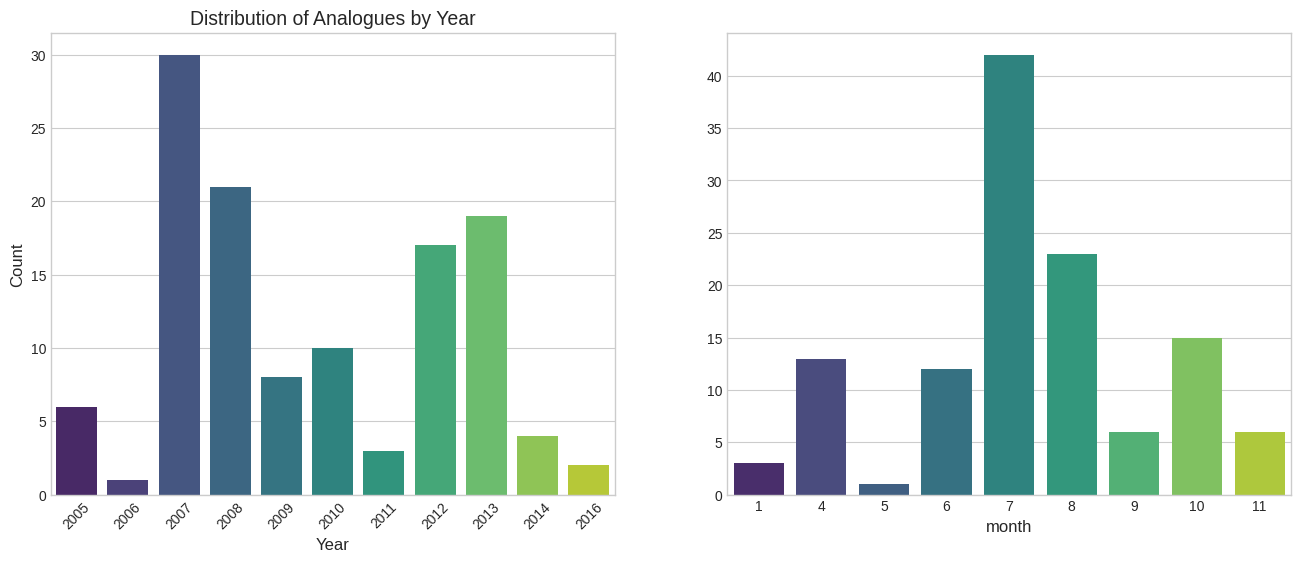

In [19]:
def visualize_analogue_distribution(results_df):
    """
    Visualize the distribution of analogues by year and month.
    
    Args:
        results_df (pandas.DataFrame): DataFrame with analogue information
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Year distribution
    sns.countplot(x='year', data=results_df, ax=axes[0], palette='viridis')
    axes[0].set_title('Distribution of Analogues by Year', fontsize=14)
    axes[0].set_xlabel('Year', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Month distribution
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_counts = results_df['month'].value_counts().sort_index()
    
    sns.barplot(x=month_counts.index, y=month_counts.values, ax=axes[1], palette='viridis')
    axes[1].set_xticklabels(month_names)
    axes[1].set_title('Distribution of Analogues by Month', fontsize=14)
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def visualize_similarity_scores(results_df):
    """
    Visualize the distribution of similarity scores.
    
    Args:
        results_df (pandas.DataFrame): DataFrame with analogue information
    """
    plt.figure(figsize=(12, 6))
    
    # Remove the target event (rank 0) if present
    plot_df = results_df[results_df['rank'] != '0'].copy()
    
    # Convert rank to numeric if it's not already
    if plot_df['rank'].dtype != 'int64':
        plot_df['rank'] = plot_df['rank'].astype(int)
    
    # Sort by rank
    plot_df = plot_df.sort_values('rank')
    
    # Plot similarity scores
    plt.bar(plot_df['rank'], plot_df['score'], color='skyblue')
    plt.xlabel('Analogue Rank', fontsize=12)
    plt.ylabel('Similarity Score', fontsize=12)
    plt.title('Similarity Scores by Analogue Rank', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add score threshold line at mean
    mean_score = plot_df['score'].mean()
    plt.axhline(y=mean_score, color='red', linestyle='--', alpha=0.7)
    plt.text(len(plot_df) * 0.8, mean_score * 1.02, f'Mean: {mean_score:.4f}', 
             color='red', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def attach_and_plot_analogue_data(data, analogues, location_index=500, num_analogues=5):
    """
    Attach data to analogues and visualize time series at a specific location.
    
    Args:
        data (list): List of (timestamp, data_array) tuples
        analogues (dict): Dictionary of analogue results
        location_index (int): Grid point index to visualize
        num_analogues (int): Number of top analogues to display
    """
    # Attach data to analogues
    analogues_with_data = attach_data_to_analogs(data, analogues)
    
    # Plot analogues
    plot_analogs(
        analogues_with_data,
        specified_index=location_index,
        num_analogs_to_plot=num_analogues,
        variable_list=VARIABLE_LIST
    )
    
    # Plot analogues with uncertainty band
    plot_analogs_with_band(
        analogues_with_data,
        specified_index=location_index,
        num_analogs_to_plot=num_analogues
    )
    
    return analogues_with_data

# Visualize the distribution of analogues
visualize_analogue_distribution(analogue_results_df)

# Visualize similarity scores
visualize_similarity_scores(analogue_results_df)

# Attach data and plot time series (optional - uncomment to run)
# Choose a central grid point (e.g., 500 for a 32x32 grid)
# analogues_with_data = attach_and_plot_analogue_data(
#     data=era5_data,
#     analogues=target_analogues,
#     location_index=500,  # Center of grid
#     num_analogues=5  # Top 5 analogues
# )

## Conclusion

This notebook demonstrates the implementation of traditional similarity metrics for weather analogue searching. The main conclusions are:

1. Different similarity metrics (cosine, Euclidean, SSIM) capture different aspects of weather pattern similarity.
2. The enhanced analogue search method provides better control over the sliding window approach and overlap handling.
3. Spatial and variable weights play a crucial role in improving the analogue search results.
4. Temporal patterns in analogues can reveal seasonal characteristics of weather events.

Future work could explore:
- Combining multiple similarity metrics for improved results
- Implementing machine learning approaches for analogue searching
- Extending the analysis to include precipitation and other impact variables